## Cluster analysis in python

This Jupyter notebook accompanies slides from the guest lecture I ([Tal Yarkoni](https://talyarkoni.org)) gave in Alex Huth's Neuroscience Data Analysis class. Code needed to generate most of the figures is included.

As usual, we'll begin by importing all the things we need.

In [1]:
%matplotlib inline
import requests
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

Let's build ourselves a dataset to play with. We'll grabbing a bunch of neuron measurements from the [neuromorpho.org](http://neuromorpho.org) website via its API. I've preselected 122 neurons drawn from 3 very different groups. Each group contains neurons from a different species, brain region, and type. They are:
* Mouse hippocampal granule neurons
* Human neocortical pyramidal neurons
* Zebrafish olfactory bulb output neurons

The list below gives the identifying names of the individual neurons in the Neuromorpho database.

In [2]:
neuron_names = [
"DD13-10-c5-1",
"DD13-10-c5-2",
"DD13-10-c6-1",
"DD13-10-c6-2",
"DD13-10-c6-3",
"DD13-10-c6-4",
"DD13-10-c6-5",
"DD13-10-c6-6",
"DD13-10-c7-1",
"DD13-10-c7-2",
"DD13-10-c7-3",
"DD13-10-c8-1",
"DD13-10-c8-2",
"DD13-10-c8-3",
"DD13-101-c5-1",
"DD13-101-c5-2",
"DD13-101-c6-1",
"DD13-101-c6-2",
"DD13-101-c7-1",
"DD13-101-c7-2",
"DD13-101-c7-3",
"DD13-101-c8-1",
"DD13-101-c8-2",
"DD13-101-c9-1",
"DD13-101-c9-2",
"DD13-18-c10-1",
"DD13-18-c10-2",
"DD13-18-c6-1",
"DD13-18-c6-2",
"DD13-18-c6-3",
"DD13-18-c7-1",
"DD13-18-c7-2",
"DD13-18-c7-3",
"DD13-18-c7-4",
"DD13-18-c7-5",
"DD13-18-c9-1",
"DD13-18-c9-2",
"173-cel-1",
"h173-cel-10",
"h173-cel-13",
"h173-cel-2",
"h173-cel-3-12",
"h173-cel-4-11",
"h173-cel-5",
"h173-cel-6",
"h173-cel-7",
"h173-cel-8",
"h173-cel-9",
"h184a-cel-1",
"h184a-cel-10",
"h184a-cel-11",
"h184a-cel-12",
"h184a-cel-13",
"h184a-cel-14",
"h184a-cel-2",
"h184a-cel-3",
"h184a-cel-5",
"h184a-cel-6",
"h184a-cel-7",
"h184a-cel-8",
"h184a-cel-9",
"h184b-cel-1",
"h184b-cel-10",
"h184b-cel-11",
"h184b-cel-12",
"h184b-cel-2",
"h184b-cel-3",
"h184b-cel-4",
"h184b-cel-5",
"h184b-cel-6",
"h184b-cel-8",
"h184b-cel-9",
"h184c-cel-10",
"h184c-cel-2",
"h184c-cel-6",
"h184c-cel-7",
"h184c-cel-9",
"h189a-cel-1",
"h189a-cel-10",
"dG-1",
"dG-2",
"dG-3",
"dG-4",
"dG-5",
"dG-6",
"dG-7",
"lG-1",
"lG-2",
"lG-3",
"lG-4",
"lG-5",
"lG-6",
"lG-7",
"maG-1",
"maG-2",
"maG-3",
"maG-4",
"maG-5",
"maG-6",
"maG-7",
"mdG-L1",
"mdG-L2",
"mdG-L3",
"mdG-L4",
"mdG-L5",
"mdG-L6",
"mdG-L7",
"mdG-T1",
"mdG-T2",
"mdG-T3",
"mdG-T4",
"mdG-T5",
"mdG-T6",
"vaG-1",
"vaG-2",
"vaG-3",
"vaG-4",
"vaG-5",
"vaG-6",
"vaG-7",
"vmG-1",
"vmG-2",
]

# Create a list of true labels
true_labs = ['mouse'] * 37 + ['human'] * 42 + ['zebrafish'] * 43

Given this set of target neurons, we can use the `requests` package to retrieve JSON data directly from the Neuromorpho API. Each result contains a dictionary of measurements for that particular neuron. We'll loop over neuron names, then concatenate them into a single pandas DataFrame. The whole thing may take a minute or two, reflecting the fact that we're calling a remote API 122 times.

In [3]:
# Store all neuron results
measurements = []

# The API route we'll call; %s is a placeholder for each neuron name
url_template = "http://neuromorpho.org/api/morphometry/name/%s"

# Loop over neurons and append a pandas Series created from the retrieved JSON
# to the measurements list
for nn in neuron_names:
    url = url_template % nn
    result = requests.get(url).json()
    ser = pd.Series(result)
    measurements.append(ser)

# Concatenate the series into a DataFrame along the column axis
data = pd.concat(measurements, axis=1).T

# Make sure all non-string columns are represented as numeric types
cols = [x for x in data.columns if x not in ['neuron_name', 'pk_classic']]
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')

# Add the true labels to the dataset
data['species'] = true_labs

Let's take a look at our assembled dataset:

In [4]:
data

,neuron_name,surface,volume,neuron_id,soma_Surface,n_stems,n_bifs,n_branch,width,height,...,branch_Order,contraction,fragmentation,partition_asymmetry,pk_classic,bif_ampl_local,fractal_Dim,bif_ampl_remote,length,species
0,DD13-10-c5-1,49.9682,1.12429,80453,266.144,1.0,3.0,7.0,13.7504,98.8300,...,3.0,0.894654,68.0,0.666667,2,70.5745,1.02631,26.0060,176.726,mouse
1,DD13-10-c5-2,95.2498,2.14312,80454,297.499,1.0,6.0,13.0,38.5400,175.1500,...,5.0,0.945537,110.0,0.583333,2,75.6305,1.01930,67.5956,336.877,mouse
2,DD13-10-c6-1,138.2310,3.11020,80455,298.157,1.0,4.0,9.0,63.1010,194.9190,...,3.0,0.938918,161.0,0.333333,2,51.5310,1.01742,27.4542,488.892,mouse
3,DD13-10-c6-2,101.0840,2.27438,80456,232.768,1.0,10.0,21.0,49.0221,99.4720,...,7.0,0.940114,150.0,0.714286,2,65.4365,1.02202,45.4139,357.510,mouse
4,DD13-10-c6-3,78.6540,1.76971,80457,213.964,1.0,7.0,15.0,29.9807,93.5995,...,4.0,0.919178,131.0,0.166667,2,53.0259,1.02928,43.4085,278.182,mouse
5,DD13-10-c6-4,76.7121,1.72602,80458,320.233,1.0,3.0,7.0,28.1305,133.7000,...,2.0,0.954650,98.0,0.000000,2,46.1796,1.01173,24.5932,271.313,mouse
6,DD13-10-c6-5,89.6733,2.01765,80459,244.719,1.0,7.0,15.0,46.0457,113.4130,...,5.0,0.961030,127.0,0.600000,2,71.9166,1.01336,51.1020,317.154,mouse
7,DD13-10-c6-6,140.6860,3.16544,80460,263.461,1.0,12.0,25.0,58.6167,101.8730,...,5.0,0.966372,221.0,0.363131,2,56.4359,1.01132,41.5688,497.576,mouse
8,DD13-10-c7-1,101.1630,2.27616,80461,304.187,1.0,10.0,21.0,55.7901,92.3695,...,5.0,0.948867,162.0,0.392063,2,63.9632,1.02136,45.6562,357.790,mouse
9,DD13-10-c7-2,85.8283,1.93114,80462,257.151,1.0,8.0,17.0,22.3798,164.5700,...,7.0,0.962180,136.0,0.700000,2,66.2508,1.01294,39.5923,303.555,mouse


There are a whole bunch of morphological measurements here to explore! Some of the variables (e.g., number of bifurcations and volume) are self-explanatory. Others are not. I'm not a neuroanatomist, and have no idea what most of them mean, but thankfully, operational definitions can be found in the [L-Measure documentation](http://cng.gmu.edu:8080/Lm/help/index.htm).

### A quick sanity check
Before doing anything useful with this data, let's just plot all of our neurons along two dimensions. This will give us a quick sense of whether any clustering of neurons is apparent at a cursory glance. We'll use `Volume` and `Width` as our two dimensions (feel free to replace them with other columns).

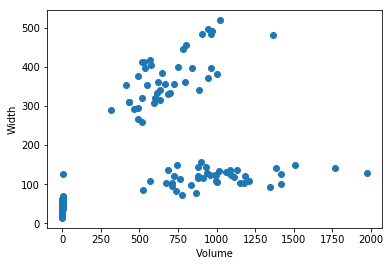

In [5]:
# Generate a basic scatterplot with matplotlib
plt.scatter(data['volume'], data['width'])
plt.xlabel("Volume")
plt.ylabel("Width");

Each point in the above plot represents a single neuron. While the neurons are unlabeled, we can clearly see the clustering structure. We have a group of neurons at bottom left that are tiny and not very wide (probably the mouse hippocampus neurons), and the other two groups (the human and zebrafish neurons) can be perfectly distinguished by their width.

Let's take a more systematic look at the relationships between the different variables in our dataset. We'll use the convenient DataFrame `.corr` method in pandas to generate a pairwise correlation matrix, which we can then feed to seaborn's `heatmap` function to generate a nice visualization.

Note that I'm collapsing over the 3 groups of neurons here, so you might reasonably worry that these correlations are going to primarily reflect differences between, rather than within, neuron groups. As an exercise, you may want to create this plot separately for each group of neurons.

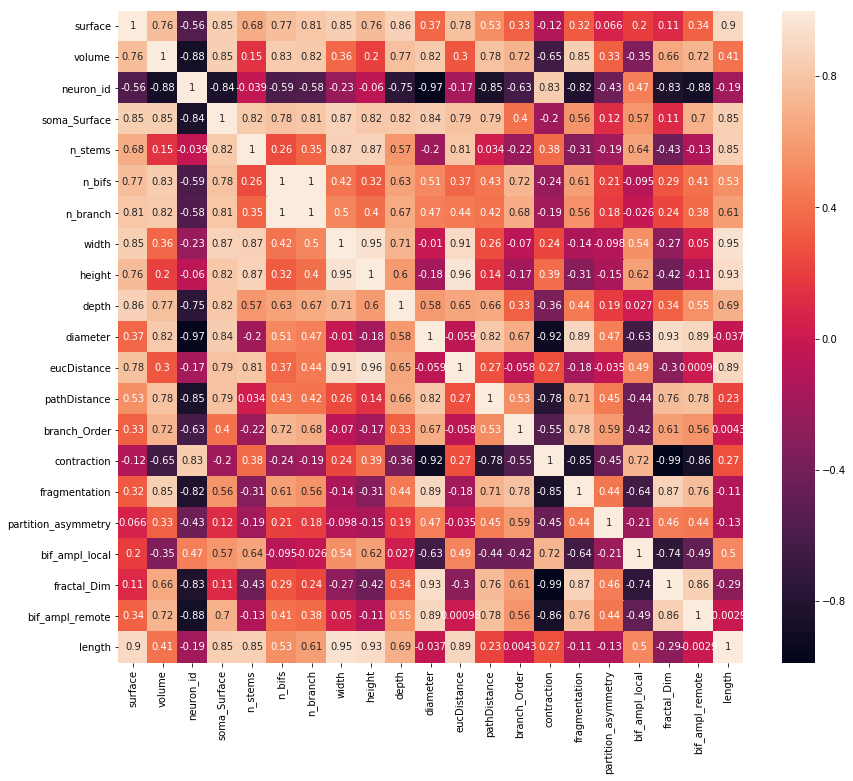

In [6]:
corrs = data.corr()
sns.heatmap(corrs, annot=True, )
plt.gcf().set_size_inches(14, 12)

# As an exercise, run the above separately for each value of 'species' in the dataset

The above plot is helpful for picking out relatively independent features to use in our clustering. We *could* use all of the columns, but many of them are redundant, and some are probably just noise. So let's pick out a small number of features—say, 4. We'll go with `volume`, `n_bifs`, `n_stems`, and `contraction` (for no particular reason).

To visualize this subset of the data more systematically, we can use seaborn's awesome `pairplot`, which by default generates a matrix of kernel density plots (on the diagonal) and pairwise scatterplots (on the off-diagonals). Let's also split by neuron group (i.e., `'species'`) so we can see the ground truth (which our clustering will hopefully recover) more clearly.

/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


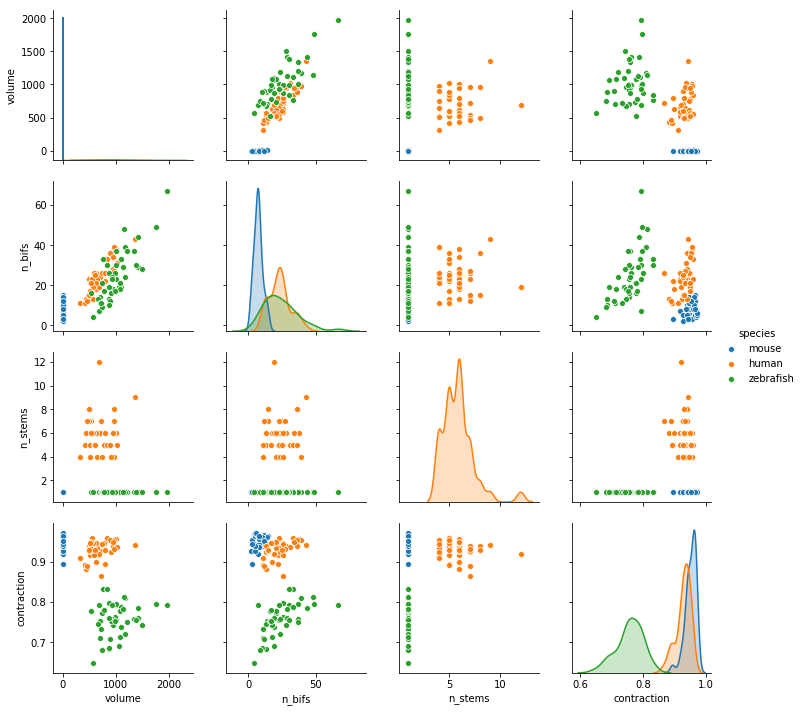

In [15]:
plot_cols = ['volume', 'n_bifs', 'n_stems', 'contraction', 'species']
plot_data = data[plot_cols]
sns.pairplot(plot_data, hue='species');

Once again we can see that the different classes of neurons are nicely separable on most of our dimensions—hopefully this means the true clusters will be easy to recover!

### k-means clustering
Now let's run a clustering analysis on our data. We'll use scikit-learn's k-means implementation, which we can find in the `cluster` module we imported earlier. We'll initialize a `KMeans` estimator with `n_clusters=3`.

In [17]:
# Columns to use in clustering
features = ['volume', 'n_bifs', 'n_stems', 'contraction']

# Initialize the KMeans instance
n_clusters = 3
kmeans = cluster.KMeans(n_clusters)

# Fit the data and predict labels (we can also use .fit_predict
# to do this one step)
kmeans.fit(data[features])
labels = kmeans.predict(data[features])

Now let's repeat the `pairplot` we generated earlier, but this time coloring the points by the k-means-assigned labels, rather than by the ground truth.

/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


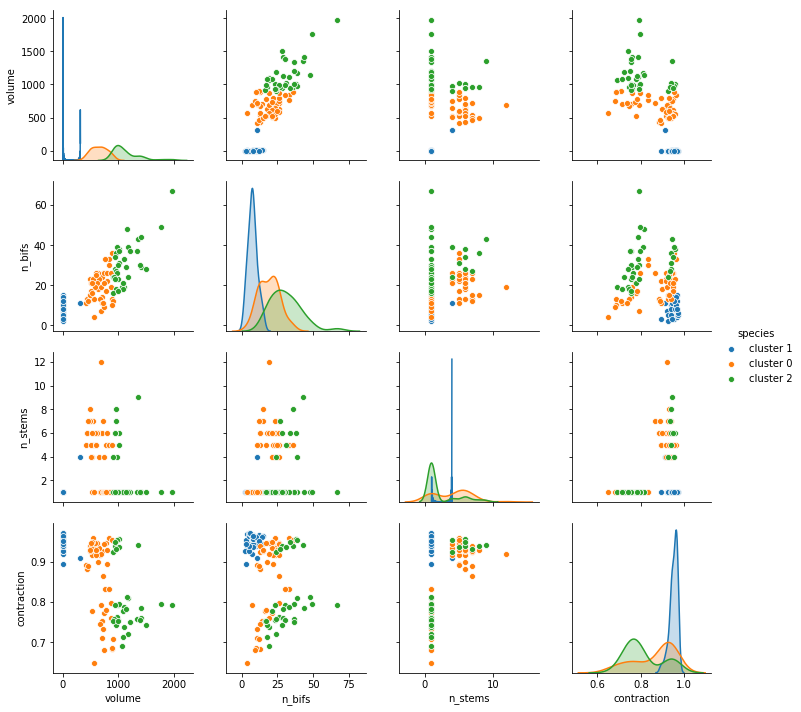

In [20]:
# Show pair plot again, but with k-means-assigned labels
plot_data = data[features]
plot_data['species'] = ['cluster %d' % x for x in labels]
sns.pairplot(plot_data, hue='species');

If you compare the two versions, you'll note that while the k-means clustering gets *some* things right, it clearly screws up assignment in many places.

There are various things we might want to worry about here, but one clear problem is that we haven't normalized our features in any way. Because k-means operates in Euclidian space, what's probably happening here is that the `volume` features (which has a much larger range than the other features) is dominating the clustering. We can avoid this pitfall by rescaling each of our features to mean-zero, unit variance.

Let's repeat the above clustering, with that extra preprocessing step.

/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


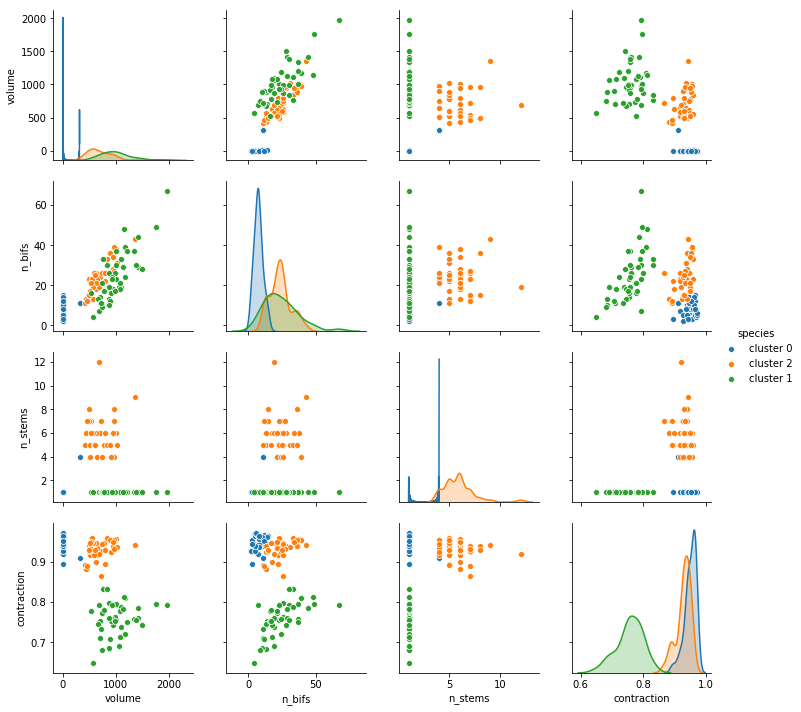

In [21]:
# Standardize each column
scaled_data = data[features].apply (lambda x: (x - x.mean()) / x.std())
labels = kmeans.fit_predict(scaled_data)

# Show pair plot again, but with k-means-assigned labels
plot_data = data[features]
plot_data['species'] = ['cluster %d' % x for x in labels]
sns.pairplot(plot_data, hue='species');

That looks much better! Now the clustering is *almost* perfect.

#### How many clusters?
As we discussed in class, we don't usually have the luxury of knowing how many clusters there really are in our data. In fact, in most real-world scientific data, there arguably *are* no "true" clusters; clustering analysis is typically just a means of describing high-dimensional data in lower-dimensional spaces humans can easily understand and visualize. Still, we might want some heuristic method(s) we can use to help pick out "reasonable" values of *k*. Scikit-learn's `metrics` module implements a number we can use.

Here's an example that uses the [Silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)). We'll repeat our cluster analysis for values of *k* between 2 and 20, plotting the mean silhouette score for each value. Then we could use the maximal value as our chosen k.

(As a more advanced exercise, you could try to quantify the uncertainty around the points in the plot below, which might provide a better basis for determining whether or not the apparent differences in silhouette score as a function of *k* are actually meaningful. But, like good scientists, we'll just go ahead and ignore inferential uncertainty here, because it makes our life difficult.)

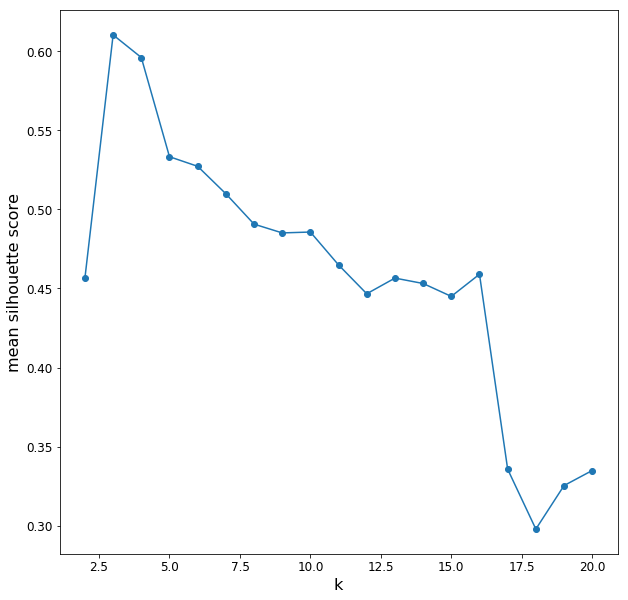

In [11]:
# Repeat k-means clustering for different values of k
n_clusters = list(range(2, 21))
scores = []
for nc in n_clusters:
    kmeans = cluster.KMeans(nc)
    labels = kmeans.fit_predict(scaled_data)
    score = metrics.silhouette_score(scaled_data, labels)
    scores.append(score)

# Plot silhouette score as function of k
plt.plot(n_clusters, scores, '-o')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel("k", fontsize=16)
plt.ylabel("mean silhouette score", fontsize=16)
plt.gcf().set_size_inches(10, 10)

Happily, it turns out that the maximum value is at 3, which just so happens to be the ground truth. We probably shouldn't read too much into this though, as (a) this is a particularly easy clustering problem, (b) a 4-cluster solution is only slightly less good, and (c) different clustering metrics often diverge sharply (as an exercise, you can switch out the silhouette score for some other clustering metrics available in sklearn).

### Other clustering approaches
Scikit-learn's consistent, simple API makes it easy to try different methods, so let's take advantage of that and repeat our cluster analysis using a hierarchical clustering methods—agglomerative clustering with Ward linkage. The code will look almost identical.

/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, ke

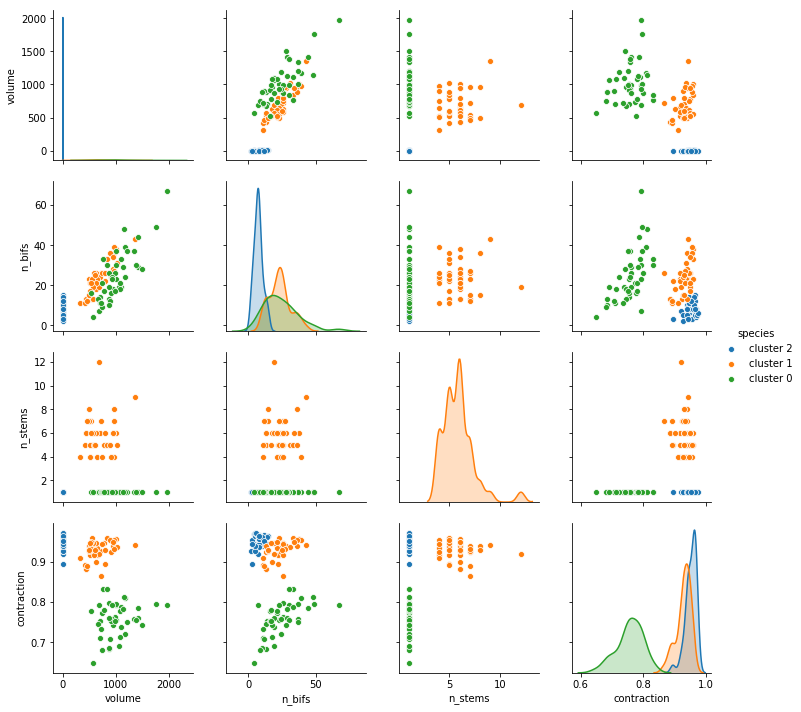

In [12]:
# Initialize our clusterer
n_clusters = 3
agg = cluster.AgglomerativeClustering(n_clusters)

# Fit the scaled data and predict labels
labels = agg.fit_predict(scaled_data)

# Plot
plot_data = data[features]
plot_data['species'] = ['cluster %d' % x for x in labels]
sns.pairplot(plot_data, hue='species');

### The SciPy version
The SciPy library also supports various clustering methods. Once nice thing about SciPy's implementation is that it provides some nice plotting tools to help us make sense of our results. Let's repeat our Ward clustering, but this time we'll plot a dendrogram displaying how the clusters are progressively built up.

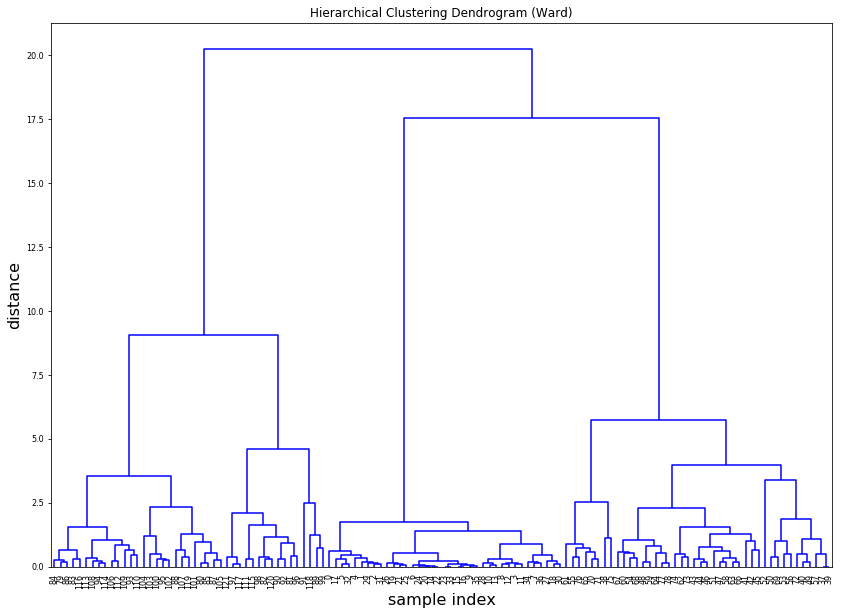

In [13]:
linkage_matrix = linkage(scaled_data, 'ward')
figure = plt.figure(figsize=(7.5, 5))
dendrogram(
    linkage_matrix,
    color_threshold=0,
)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('sample index', fontsize=16)
plt.ylabel('distance', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.gcf().set_size_inches(14, 10)
plt.show()